In [71]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

In [72]:
data = pd.read_csv('assets_wide.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# data = data.dropna()
# display(data)

In [73]:
target = (data > data.shift(1)).astype(int)
display(target)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-04,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,1,0,0,0,1,0
2012-01-05,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2012-01-06,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2012-01-09,0,0,0,1,0,0,0,1,1,1,...,1,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


## Test data correctness

In [74]:
test_df = pd.DataFrame({'Close_yesterday': data['SPY'].shift(1),'Close Tody':data['SPY'],'Target': target['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450676,0
2012-01-04,100.450676,100.608231,1
2012-01-05,100.608231,100.876099,1
2012-01-06,100.876099,100.616119,0
2012-01-09,100.616119,100.860359,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


In [75]:
def create_X_y_rolling(feature, target, window_size):
    X, y = [], []
    for i in range(len(feature) - window_size):
        window = feature.iloc[i:i + window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value 
        X.append(normalized_window)
    for i in range(len(target) - window_size):
         y.append(target.iloc[i + window_size])
    X = np.array(X)
    y = np.array(y)
    return X, y

window_size = 30
X, y = create_X_y_rolling(data, target, window_size)
print(X)

[[[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 0.98290287 1.00534658 0.98728582]
  [1.         1.         1.         ... 0.99213559 0.9930085  0.9850746 ]
  ...
  [1.         1.         1.         ... 1.07043958 1.067037   1.13967197]
  [1.         1.         1.         ... 1.06052302 1.05038014 1.12198266]
  [1.         1.         1.         ... 1.071294   1.06251304 1.14519994]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.00939332 0.98772753 0.99776031]
  [1.         1.         1.         ... 1.00608805 0.97586402 1.00429264]
  ...
  [1.         1.         1.         ... 1.07897032 1.04479406 1.13643145]
  [1.         1.         1.         ... 1.08992866 1.05686244 1.15994773]
  [1.         1.         1.         ... 1.07879631 1.05358965 1.1584546 ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.      

In [76]:
dataset_size = len(X)
print(dataset_size)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [77]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(y_train.shape[1], activation='sigmoid'),
])



model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.01),   
              metrics=['binary_accuracy',])

cp = ModelCheckpoint(filepath='model_binary/best_binary.keras', 
                     save_best_only=True, monitor='val_loss', 
                     mode='min')

es = EarlyStopping(
    monitor='val_loss',        
    patience=10,                
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()




Epoch 1/100


c:\Users\Shelly\Desktop\KU\18_Bachelor_project\venv_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - binary_accuracy: 0.5515 - loss: 0.6685 - val_binary_accuracy: 0.5065 - val_loss: 0.7309
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.5530 - loss: 0.6594 - val_binary_accuracy: 0.5009 - val_loss: 0.7321
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - binary_accuracy: 0.5576 - loss: 0.6597 - val_binary_accuracy: 0.4992 - val_loss: 0.7405
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.5550 - loss: 0.6595 - val_binary_accuracy: 0.4998 - val_loss: 0.7429
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.5601 - loss: 0.6583 - val_binary_accuracy: 0.4992 - val_loss: 0.7292
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.5604 - loss: 0.6605 - val_binary_accuracy: 0.5073 - val_loss: 0.7362
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.5567 - loss: 0.6596 - val_binary_accuracy: 0.5008 - val_loss: 0.7304
Epoch 8/100
43/43 

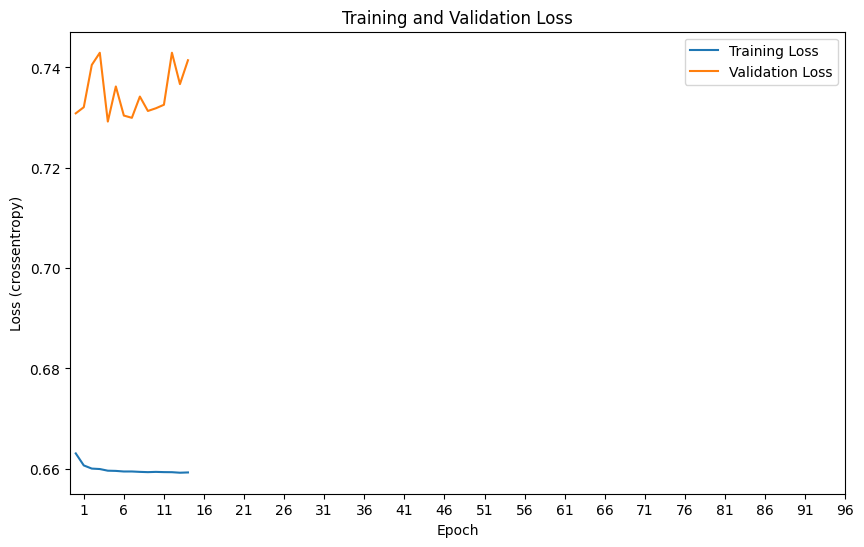

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (crossentropy)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [79]:

from sklearn.metrics import f1_score, precision_score, recall_score

# Flatten predictions and ground truth
y_val_pred = model.predict(X_val)
# print(y_val_pred)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

print("F1:", f1_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Precision:", precision_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Recall:", recall_score(y_val.flatten(), y_val_pred_binary.flatten()))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
F1: 0.5106568832983928
Precision: 0.47902327105866926
Recall: 0.5467639356528246


In [80]:
model = load_model('model_binary/best_binary.keras')
index_series = data.index[train_size + val_size + window_size:]

y_pred = model.predict(X_test)
display(y_pred)
# y_pred_mean = y_pred.mean(axis=0)
y_pred_classes = (y_pred > 0.6).astype(int)

Predict_result_df = pd.DataFrame(y_pred_classes, index=index_series, columns=data.columns)


display(Predict_result_df)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


array([[0.2765203 , 0.4208932 , 0.20418474, ..., 0.51107854, 0.5274612 ,
        0.49977648],
       [0.27649105, 0.42089787, 0.20416212, ..., 0.51109093, 0.52748984,
        0.499804  ],
       [0.27666053, 0.42089418, 0.20430657, ..., 0.5110645 , 0.52739894,
        0.49973315],
       ...,
       [0.27674344, 0.42079005, 0.20433511, ..., 0.5109726 , 0.5272264 ,
        0.499513  ],
       [0.2768272 , 0.4207737 , 0.20440179, ..., 0.51094985, 0.5271585 ,
        0.4994411 ],
       [0.2768198 , 0.4207686 , 0.20439586, ..., 0.51094896, 0.52715564,
        0.49945107]], dtype=float32)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
true_test = target.iloc[train_size + val_size + window_size:]
true_test

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [82]:
from sklearn.metrics import accuracy_score

actual_flat = true_test.to_numpy().flatten()
predicted_flat = Predict_result_df.to_numpy().flatten()

accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.4861


In [83]:
average = Predict_result_df
display(average)
num_ones = (average == 1).sum()
num_zeros = (average == 0).sum()
y_pred_mean = (num_ones > num_zeros).astype(int)
y_pred_mean_df = pd.DataFrame(y_pred_mean, index = Predict_result_df.columns, columns=['Predicted Trend'])
display(y_pred_mean_df.T)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2025-03-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Predicted Trend,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
yesterday_prices = data.iloc[-2] 
today_prices_actual = data.iloc[-1] 
y_actual = target.iloc[-1] 
today_taget_predicted = pd.Series(y_pred_mean, index=Predict_result_df.columns)

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_actual_target': y_actual,
    'Today_pred_target': y_pred_mean,
})


tickers_names = target.columns

correct_list = []
for ticker in tickers_names:
    predict = today_taget_predicted[ticker]
    actual = y_actual[ticker]
    if predict == actual:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today actual target'] = comparison_df['Today_actual_target'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred_target'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_binary_6.csv', index=False)

Count of correct predictions: 30
accuracy: 0.9090909090909091


,Yesterday actual,Today actual,Today actual target,Today pred target,Correct
AIEQ,37.66,36.85,0,0,1
ASHR.L,10.46,10.34,0,0,1
BCHN.L,97.08,92.71,0,0,1
CORN,18.51,18.46,0,0,1
DBO,14.13,13.97,0,0,1
EDEN,105.33,105.17,0,0,1
EMXC,56.11,55.18,0,0,1
EWA,23.75,23.47,0,0,1
EWC,41.25,40.57,0,0,1
EWG,37.59,37.39,0,0,1
